## Visualize results learning curves of FEM, RLS & ILS

In [1]:
using Revise
using JLD
using MAT
using Statistics
using StatsPlots
using LaTeXStrings
using Plots
font = Plots.font(11)
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font);

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /home/wmkouw/.julia/packages/Revise/OgnOk/src/packagedef.jl:1381


In [2]:
include("util.jl");

In [3]:
alpha = 0.2
linewidth = 3;
styles = [:solid, :dash, :dot, :dashdot];

### Load results

In [4]:
sample_sizes = 2 .^collect(7:11)
which_sizes = 1:length(sample_sizes)
num_sizes = length(which_sizes)
sample_sizes[which_sizes]'

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 128  256  512  1024  2048

In [5]:
# Number of repetitions
num_repeats = 200

mτ_0 = 100.0
stde = 0.02
deg = 3
pol = 3
order = 4
basis = 22

results_sim_FEM = zeros(num_sizes,2)
results_prd_FEM = zeros(num_sizes,2)
results_sim_RLS = zeros(num_sizes,2)
results_prd_RLS = zeros(num_sizes,2)
results_sim_ILS = zeros(num_sizes,2)
results_prd_ILS = zeros(num_sizes,2)

RMS_sim_FEM = zeros(num_repeats,num_sizes)
RMS_prd_FEM = zeros(num_repeats,num_sizes)
RMS_sim_RLS = zeros(num_repeats,num_sizes)
RMS_prd_RLS = zeros(num_repeats,num_sizes)
RMS_sim_ILS = zeros(num_repeats,num_sizes)
RMS_prd_ILS = zeros(num_repeats,num_sizes)

for r = 1:num_repeats

    # Load
    FEM_data = load("results/results-NARMAX_FEM_stde"*string(stde)*"_pol"*string(pol)*"_M"*string(order)*"_N"*string(basis)*"_degree"*string(deg)*"_mtau_"*string(mτ_0)*"_r"*string(r)*".jld")
    RMS_prd_FEM[r,:] = FEM_data["RMS_prd"][which_sizes]
    RMS_sim_FEM[r,:] = FEM_data["RMS_sim"][which_sizes]

    RLS_data = load("results/results-NARMAX_RLS_stde"*string(stde)*"_pol"*string(pol)*"_M"*string(order)*"_N"*string(basis)*"_degree"*string(deg)*"_r"*string(r)*".jld")
    RMS_prd_RLS[r,:] = RLS_data["RMS_prd"][which_sizes]
    RMS_sim_RLS[r,:] = RLS_data["RMS_sim"][which_sizes]

    ILS_data = matread("results/results-NARMAX_ILS_stde"*string(stde)*"_pol"*string(pol)*"_M"*string(order)*"_N"*string(basis)*"_degree"*string(deg)*"_r"*string(r)*".mat")
    RMS_prd_ILS[r,:] = ILS_data["RMS_prd"][which_sizes]
    RMS_sim_ILS[r,:] = ILS_data["RMS_sim"][which_sizes]

end    

# Map all infinities to NaN
RMS_prd_FEM[isinf.(RMS_prd_FEM)] .= NaN
RMS_sim_FEM[isinf.(RMS_sim_FEM)] .= NaN
RMS_prd_RLS[isinf.(RMS_prd_RLS)] .= NaN
RMS_sim_RLS[isinf.(RMS_sim_RLS)] .= NaN
RMS_prd_ILS[isinf.(RMS_prd_ILS)] .= NaN
RMS_sim_ILS[isinf.(RMS_sim_ILS)] .= NaN
    
# Check for proportion of instable
instab_sim_FEM = mean(isnan.(RMS_sim_FEM),dims=1)
instab_prd_FEM = mean(isnan.(RMS_prd_FEM),dims=1)
instab_sim_RLS = mean(isnan.(RMS_sim_RLS),dims=1)
instab_prd_RLS = mean(isnan.(RMS_prd_RLS),dims=1)
instab_sim_ILS = mean(isnan.(RMS_sim_ILS),dims=1)
instab_prd_ILS = mean(isnan.(RMS_prd_ILS),dims=1)

# Populate RMS arrays
trim_prctile = 0.05
for n = 1:num_sizes
    results_sim_FEM[n,1] = tmean(filter(!isnan, RMS_sim_FEM[:,n]), tr=trim_prctile)
    results_sim_FEM[n,2] = trimse(filter(!isnan, RMS_sim_FEM[:,n]), tr=trim_prctile)
    results_prd_FEM[n,1] = tmean(filter(!isnan, RMS_prd_FEM[:,n]), tr=trim_prctile)
    results_prd_FEM[n,2] = trimse(filter(!isnan, RMS_prd_FEM[:,n]), tr=trim_prctile)

    results_sim_RLS[n,1] = tmean(filter(!isnan, RMS_sim_RLS[:,n]), tr=trim_prctile)
    results_sim_RLS[n,2] = trimse(filter(!isnan, RMS_sim_RLS[:,n]), tr=trim_prctile)
    results_prd_RLS[n,1] = tmean(filter(!isnan, RMS_prd_RLS[:,n]), tr=trim_prctile)
    results_prd_RLS[n,2] = trimse(filter(!isnan, RMS_prd_RLS[:,n]), tr=trim_prctile)

    results_sim_ILS[n,1] = tmean(filter(!isnan, RMS_sim_ILS[:,n]), tr=trim_prctile)
    results_sim_ILS[n,2] = trimse(filter(!isnan, RMS_sim_ILS[:,n]), tr=trim_prctile)
    results_prd_ILS[n,1] = tmean(filter(!isnan, RMS_prd_ILS[:,n]), tr=trim_prctile)
    results_prd_ILS[n,2] = trimse(filter(!isnan, RMS_prd_ILS[:,n]), tr=trim_prctile)
    
end

### Plot simulation error experiment

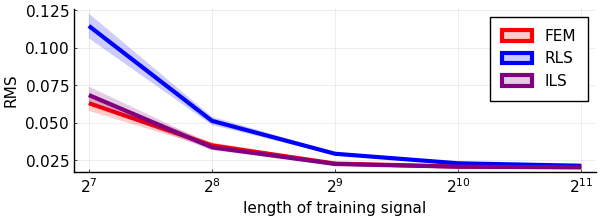

In [6]:
p1 = plot(sample_sizes[which_sizes], results_sim_FEM[:,1], 
          ribbon=[results_sim_FEM[:,2] results_sim_FEM[:,2]], 
          color="red", 
          label="FEM", 
          xscale=:log2,
          xticks=sample_sizes[which_sizes],
          linewidth=linewidth,
          fillalpha=alpha,
          xlabel="length of training signal",
          ylabel="RMS",
          size=(600,220))
plot!(sample_sizes[which_sizes], results_sim_RLS[:,1], 
     ribbon=[results_sim_RLS[:,2] results_sim_RLS[:,2]], 
     color="blue", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="RLS")
plot!(sample_sizes[which_sizes], results_sim_ILS[:,1], 
     ribbon=[results_sim_ILS[:,2] results_sim_ILS[:,2]], 
     color="purple", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="ILS")

In [7]:
savefig(p1, "figures/NARMAX-RMS-sim_deg"*string(deg)*"_order"*string(order)*"_basis"*string(basis)*".png")

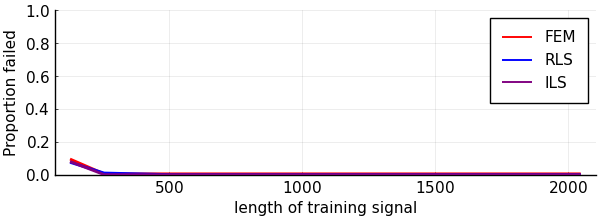

In [8]:
p2 = plot(sample_sizes[which_sizes], instab_sim_FEM', color="red", label="FEM", linewidth=2, ylabel="Proportion failed", xlabel="length of training signal", size=(600,220))
plot!(sample_sizes[which_sizes], instab_sim_RLS', color="blue", label="RLS", linewidth=2)
plot!(sample_sizes[which_sizes], instab_sim_ILS', color="purple", label="ILS", linewidth=2)
ylims!(0., 1.)

In [9]:
savefig(p2, "figures/NARMAX-propfail-sim_deg"*string(deg)*"_order"*string(order)*"_basis"*string(basis)*".png")

### Plot 1-step ahead error experiments

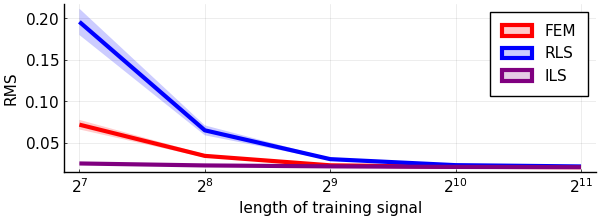

In [10]:
p3 = plot(sample_sizes[which_sizes], results_prd_FEM[:,1], 
          ribbon=[results_prd_FEM[:,2] results_prd_FEM[:,2]], 
          color="red", 
          label="FEM", 
          xscale=:log2,
          xticks=sample_sizes[which_sizes],
          linewidth=linewidth,
          fillalpha=alpha,
          xlabel="length of training signal",
          ylabel="RMS",
          size=(600,220))
plot!(sample_sizes[which_sizes], results_prd_RLS[:,1], 
     ribbon=[results_prd_RLS[:,2] results_prd_RLS[:,2]], 
     color="blue", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="RLS")
plot!(sample_sizes[which_sizes], results_prd_ILS[:,1], 
     ribbon=[results_prd_ILS[:,2] results_prd_ILS[:,2]], 
     color="purple", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="ILS")

In [11]:
savefig(p3, "figures/NARMAX-RMS-prd_deg"*string(deg)*"_order"*string(order)*"_basis"*string(basis)*".png")

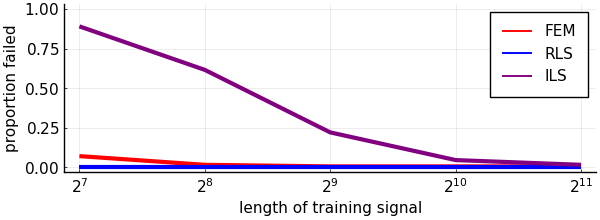

In [12]:
p4 = plot(sample_sizes[which_sizes], instab_prd_FEM', color="red", label="FEM", linewidth=3, ylabel="proportion failed", xscale=:log2, xlabel="length of training signal", size=(600,220))
plot!(sample_sizes[which_sizes], instab_prd_RLS', color="blue", label="RLS", linewidth=3, ylims=[0., 1.])
plot!(sample_sizes[which_sizes], instab_prd_ILS', color="purple", label="ILS", linewidth=3, xticks=sample_sizes[which_sizes])
# plot!(sample_sizes[which_sizes], instab_prd_SYS', color="black", label="SYS", linewidth=2)#, ylims=[0., 1.])

In [13]:
savefig(p4, "figures/NARMAX-propfail-prd_deg"*string(deg)*"_order"*string(order)*"_basis"*string(basis)*".png")

### Plot both

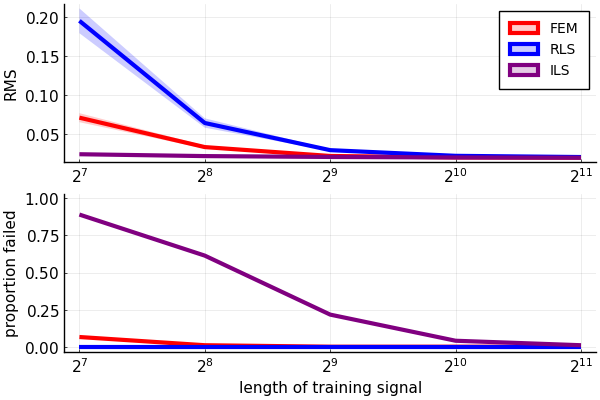

In [14]:
p5 = plot(sample_sizes[which_sizes], results_prd_FEM[:,1], 
          ribbon=[results_prd_FEM[:,2] results_prd_FEM[:,2]], 
          color="red", 
          label="FEM", 
          xscale=:log2,
          xticks=sample_sizes[which_sizes],
          linewidth=linewidth,
          fillalpha=alpha,
          ylabel="RMS",
          legendfont=10)
plot!(sample_sizes[which_sizes], results_prd_RLS[:,1], 
     ribbon=[results_prd_RLS[:,2] results_prd_RLS[:,2]], 
     color="blue", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="RLS")
plot!(sample_sizes[which_sizes], results_prd_ILS[:,1], 
     ribbon=[results_prd_ILS[:,2] results_prd_ILS[:,2]], 
     color="purple", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="ILS")

p6 = plot(sample_sizes[which_sizes], instab_prd_FEM', color="red", label="", linewidth=linewidth, xticks=sample_sizes[which_sizes], ylabel="proportion failed", xscale=:log2, xlabel="length of training signal", size=(600,220))
plot!(sample_sizes[which_sizes], instab_prd_RLS', color="blue", label="", linewidth=linewidth, ylims=[0., 1.])
plot!(sample_sizes[which_sizes], instab_prd_ILS', color="purple", label="", linewidth=linewidth)

p7 = plot(p5, p6, layout=(2,1), size=(600,400))

In [15]:
savefig(p7, "figures/NARMAX-prd_deg"*string(deg)*"_order"*string(order)*"_basis"*string(basis)*".png")